In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path1 = '/content/drive/MyDrive/reshift estimation dataset/filtered_redshift_data_2sigma.h5'
path2 = '/content/drive/MyDrive/reshift estimation dataset/new_dataset64x64.hdf5'

In [ ]:
import h5py
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers , models, datasets, Input
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
with h5py.File(path1 , 'r') as hf:
    images = np.array(hf['images'])
    redshifts = np.array(hf['specz_redshift'])
    redshift_err = np.array(hf['specz_redshift_err'])

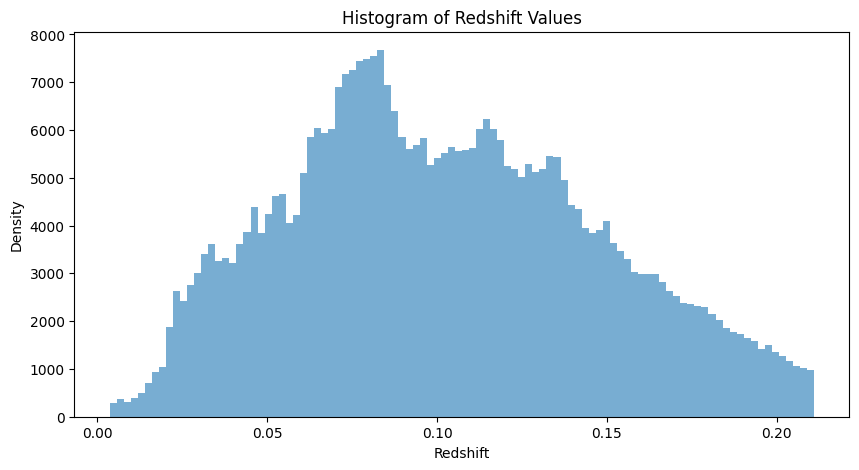

In [ ]:
#plotting histogram of redshift values befoe normalization

plt.figure(figsize=(10, 5))
plt.hist(redshifts, bins=100, alpha=0.6, label="Histogram")
plt.title("Histogram of Redshift Values")
plt.xlabel("Redshift")
plt.ylabel("Density")
plt.show()


In [ ]:
images.shape

(384711, 5, 32, 32)

In [ ]:
 # From (samples, channels, height, width) to (samples, height, width, channels)
images = np.transpose(images, (0, 2, 3, 1))



images = images / 255
redshifts = (redshifts - redshifts.min()) /(redshifts.max() - redshifts.min())

In [ ]:
X_train , X_val = train_test_split(images , test_size = 0.2 ,random_state = 42)
y_train , y_val = train_test_split(redshifts , test_size = 0.2 ,random_state = 42)

In [ ]:
# Reshape y_train and y_val to have an explicit shape of (num_samples, 1)
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

In [ ]:
inputs = tf.keras.Input(shape=(32, 32, 5))  # Input layer

x = tf.keras.layers.Conv2D(32, (5, 5), activation='relu')(inputs)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(64, (5, 5), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(220, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model = models.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer = 'adam' , loss = 'mean_squared_error' , metrics = ['mae'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 5)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 28, 28, 32)          │           4,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 10, 10, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 220)                 │         352,220 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 220)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │          14,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 421,725 (1.61 MB)

 Trainable params: 421,725 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=60,
    validation_data=(X_val, y_val),
    batch_size=256,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/60
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - loss: 0.0260 - mae: 0.1260 - val_loss: 0.0111 - val_mae: 0.0809
Epoch 2/60
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0120 - mae: 0.0849 - val_loss: 0.0120 - val_mae: 0.0856
Epoch 3/60
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0106 - mae: 0.0797 - val_loss: 0.0096 - val_mae: 0.0759
Epoch 4/60
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0100 - mae: 0.0772 - val_loss: 0.0103 - val_mae: 0.0791
Epoch 5/60
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0096 - mae: 0.0754 - val_loss: 0.0084 - val_mae: 0.0703
Epoch 6/60
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0093 - mae: 0.0744 - val_loss: 0.0093 - val_mae: 0.0740
Epoch 7/60
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0091 - mae: 0.0732 - val_loss: 0.0073 - val_mae: 0.0647
Epoch 8/60
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0087 - mae: 0.0716 - val_loss: 0.0080 - val_mae: 0.0677
Epoch 9/60
1203/1203 ━━━━━━━━━━━━━━━━━

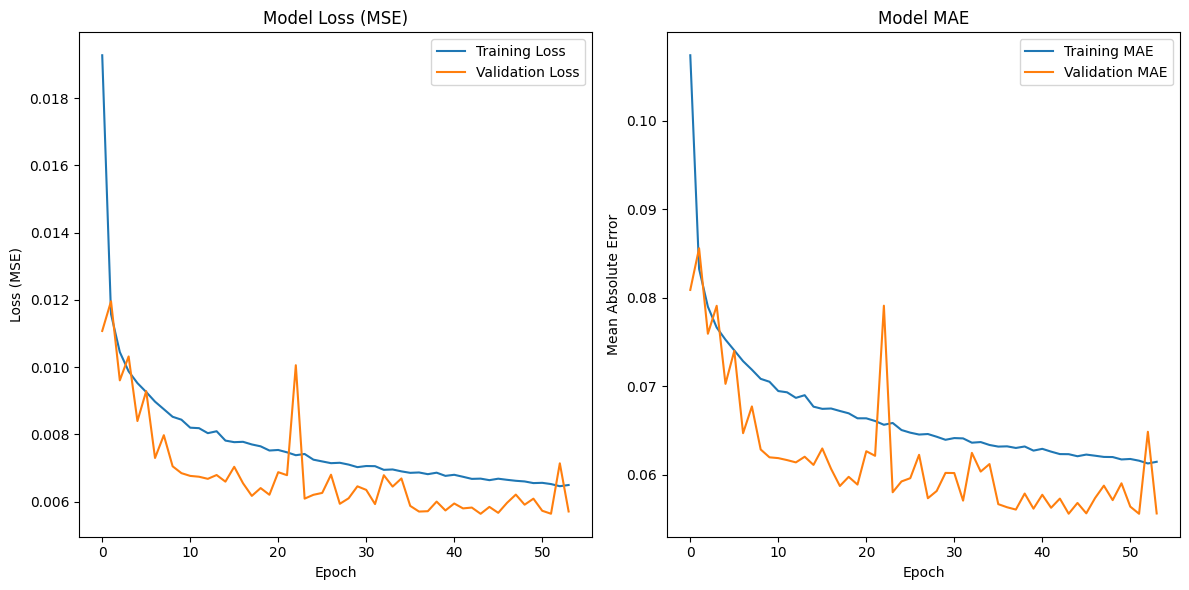

In [ ]:
import matplotlib.pyplot as plt

# Function to plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss (MSE)')
    plt.ylabel('Loss (MSE)')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    # Plot MAE
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Model MAE')
    plt.ylabel('Mean Absolute Error')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

# Call the function after training completes
plot_training_history(history)


2405/2405 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step


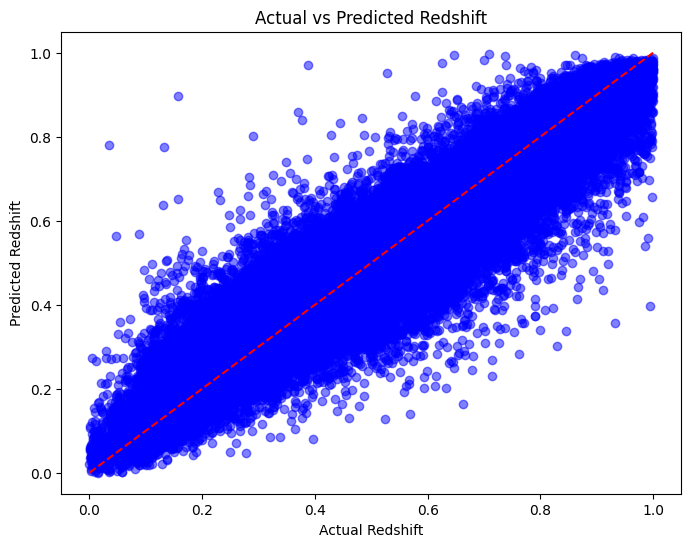

In [ ]:
# Generate predictions on the validation set
y_pred = model.predict(X_val)

# Plot the actual vs predicted redshift
plt.figure(figsize=(8, 6))
plt.scatter(y_val, y_pred, alpha=0.5, color='b')  # Scatter plot for actual vs predicted redshifts
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], 'r--')  # Plot a reference line for perfect predictions
plt.title('Actual vs Predicted Redshift')
plt.xlabel('Actual Redshift')
plt.ylabel('Predicted Redshift')
plt.show()


In [ ]:
y_pred = model.predict(X_val)

correlation_coefficient = np.corrcoef(y_val.flatten(), y_pred.flatten())[0, 1]

print(f"Correlation Coefficient: {correlation_coefficient}")


2405/2405 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Correlation Coefficient: 0.9395501149668267


In [ ]:
y_pred.shape

(76943, 1)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Assuming y_val and y_pred are already defined, and X_val is your feature matrix
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
bias = np.mean(y_pred - y_val)

# Adjusted R² calculation
n = len(y_val)       # number of observations
p = X_val.shape[1]   # number of predictors/features
adjusted_r2 = 1 - ((1 - r2) * (n - 1)) / (n - p - 1)

# Print metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Bias: {bias}")
print(f"R-squared (R²) Score: {r2}")
print(f"Adjusted R-squared: {adjusted_r2}")

Mean Absolute Error (MAE): 0.05559036135673523
Mean Squared Error (MSE): 0.005640969146043062
Bias: -0.0006707807769998908
R-squared (R²) Score: 0.8825839757919312
Adjusted R-squared: 0.8825351224207875


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Assuming y_val = true redshifts (z_spec) and y_pred = predicted redshifts (z_pred)
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
bias = np.mean(y_pred - y_val)

# Adjusted R² calculation
n = len(y_val)       # number of observations
p = X_val.shape[1]   # number of predictors/features
adjusted_r2 = 1 - ((1 - r2) * (n - 1)) / (n - p - 1)

# ∆z = |z_pred - z_spec| / (1 + z_spec)
delta_z = np.abs(y_pred - y_val) / (1 + y_val)

# Precision = 1.48 * median(∆z)
precision = 1.48 * np.median(delta_z)

# Define outlier thresholds
thresholds = [0.05, 0.10, 0.15]
outlier_fractions = {
    thresh: np.sum(delta_z > thresh) / n for thresh in thresholds
}

# Print metrics
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Bias: {bias:.6f}")
print(f"R-squared (R²) Score: {r2:.6f}")
print(f"Adjusted R-squared: {adjusted_r2:.6f}")
print(f"Precision (1.48 × median(Δz)): {precision:.6f}")

for thresh, frac in outlier_fractions.items():
    print(f"Catastrophic Outlier Fraction (Δz > {thresh:.2f}): {frac:.4%}")


Mean Absolute Error (MAE): 0.055590
Mean Squared Error (MSE): 0.005641
Bias: -0.000671
R-squared (R²) Score: 0.882584
Adjusted R-squared: 0.882535
Precision (1.48 × median(Δz)): 0.042687
Catastrophic Outlier Fraction (Δz > 0.05): 27.3176%
Catastrophic Outlier Fraction (Δz > 0.10): 5.9031%
Catastrophic Outlier Fraction (Δz > 0.15): 1.2802%


In [ ]:
model.save("modelSD2.h5")
print("Model saved as full_model.h5")

Model saved as full_model.h5
